In [ ]:
# This notebook was used to generate many of the plots present in the paper.
# Note that much of the code in this notebook is similar to the source code in https://pubs.rsc.org/en/content/articlelanding/2021/ME/D1ME00093D

In [ ]:
# A library that aids in plotting scientific diagrams
!pip install SciencePlots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
import seaborn as sns
from sklearn.decomposition import PCA
import scienceplots

# Diagram styling choices
plt.matplotlib.style.use(['science','nature'])
cool_colors = ['#0A84A4', '#F6C95E', '#6F4E7C', '#9DD967', '#CB472E', '#FFA157', '#8CDCD0']
plt.rcParams.update(plt.rcParamsDefault)

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[3], 'RF (div)': cool_colors[4], 'PSO': cool_colors[5], 'EPSO': cool_colors[6]}

In [ ]:
# Loading the relevant data from the database
X = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['x']
print("shape of X:", np.shape(X))

y = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['y']
print("shape of y:", np.shape(y))

nb_COFs = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['nb_COFs']
print("# COFs:", nb_COFs)

nb_runs = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['nb_runs']
print("# runs:", nb_runs)

nb_iterations = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['nb_iterations']
print("# iterations:", nb_iterations)

features = pickle.load(open('hydrogen_input_output.pkl', 'rb'))['features']
print(features)

shape of X: (98694, 7)
shape of y: (98694,)
# COFs: 98694
# runs: 50
# iterations: 100
['Density', 'GSA', 'VSA', 'VF', 'PV', 'LCD', 'PLD']


In [ ]:
# To determine which MOFs correspond to which rank within the database
ids_to_rank = np.argsort(y.squeeze())
y_ranks = np.arange(nb_COFs)[np.flip(ids_to_rank).argsort()] + 1

In [ ]:
bo_res     = pickle.load(open('bo_results_EI_initiate_with_10.pkl', 'rb'))  # Since we're only doing Bayesian Optimization with 10 initial MOFs
rf_res     = pickle.load(open('rf_results.pkl', 'rb'))  # Random Forest results
rf_div_res = pickle.load(open('rf_div_results.pkl', 'rb'))
rs_res     = pickle.load(open('rs_results_hydrogen.pkl', 'rb')) # Random Search results
es_res     = pickle.load(open('es_results_hydrogen.pkl', 'rb')) # Evolutionary Search results

In [ ]:
# For the diagrams related to Bayesian Optimization in 100% Explore and 100% Exploit modes:
bo_res_explore     = pickle.load(open('bo_results_max sigma_initiate_with_10.pkl', 'rb'))
bo_res_exploit     = pickle.load(open('bo_results_max y_hat_initiate_with_10.pkl', 'rb'))

In [ ]:
# Setting up Principal Component Analysis (PCA) for visualization purposes
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

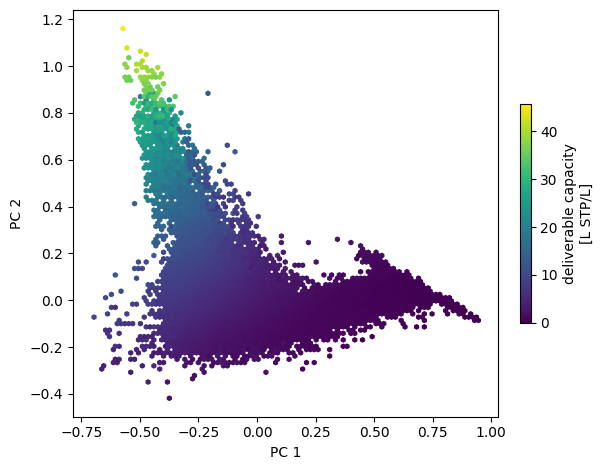

In [ ]:
# Visualizing the database with PCA:
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
cb.set_label(label="deliverable capacity\n[L STP/L]")
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('feature_space_colored_by_DC.pdf')
plt.show()

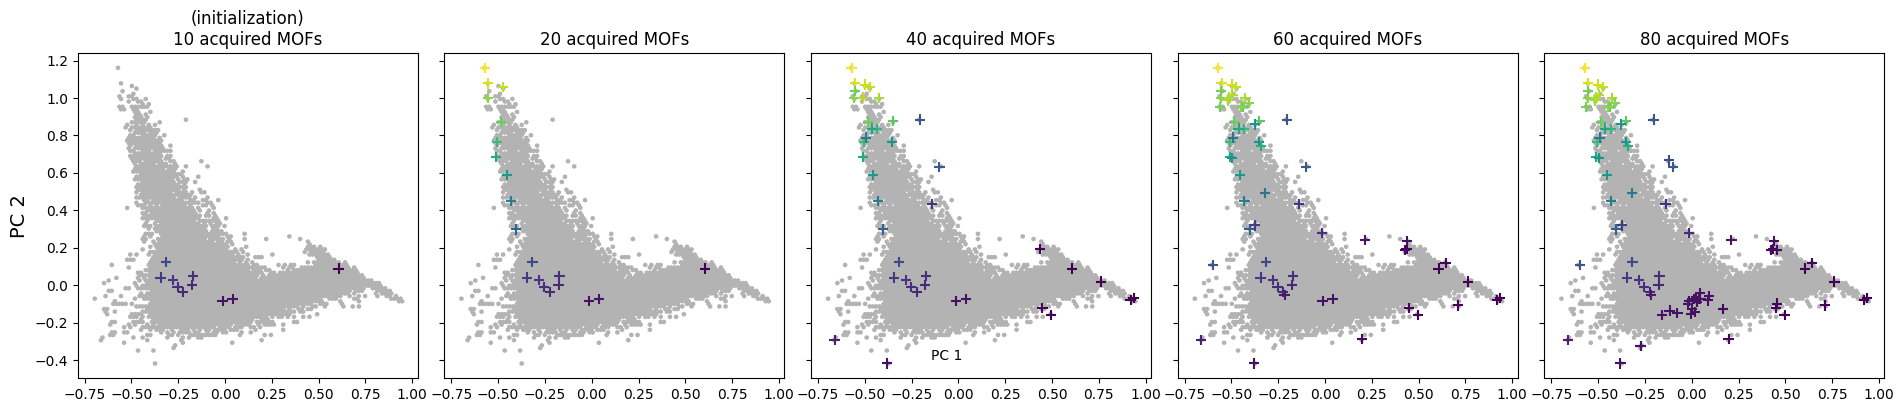

In [ ]:
# This code is to visualize which intermediate inputs are used by the Bayesian Optimization method in arriving at a final optimal value:
which_BO_run = 1  # We'll assume the first Bayesian Optimization run for visualization purposes

nb_acquired = [10, 20, 40, 60, 80]
max_y_seen = np.zeros(len(nb_acquired))
fig, ax = plt.subplots(1, len(nb_acquired), sharey=True, sharex=True, figsize=[3*6.4, 4.8])

# To get the gray background that represents the whole database
for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(nb_COFs), cmap="binary", vmin=0, vmax=1)

# Generating a separate graph for some intermediate stages of the BO run
for i in range(len(nb_acquired)):
    ids_acquired = bo_res['ids_acquired'][which_BO_run][:nb_acquired[i]]
    max_y_seen[i] = np.max(y[ids_acquired])

    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1],
                  c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    if i == 0:
        ax[i].set_title('(initialization)\n{} acquired MOFs'.format(nb_acquired[i]))
    else:
        ax[i].set_title('{} acquired MOFs'.format(nb_acquired[i]))
    ax[i].tick_params(axis='x')
ax[0].set_ylabel('PC 2', fontsize=14)

ax[2].tick_params(axis='y', labelsize=0)

fig.text(0.5, 0.2, 'PC 1', ha='center')
plt.tight_layout()
plt.savefig("feature_space_acquired_MOFs.pdf", bbox_inches="tight")
plt.show()

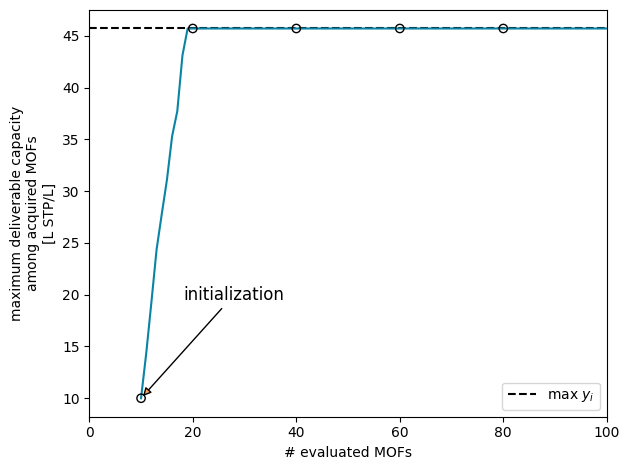

In [ ]:
# Plotting the seach efficiency curve for the first Bayesian Optimization run
y_maxes_this_run = np.array(
                    [np.max(y[bo_res['ids_acquired'][which_BO_run]][:i]) for i in range(1, 101)]
                    )
y_maxes_this_run[:(10 - 1)] = np.NaN

plt.figure()
plt.plot(range(1, 101), y_maxes_this_run, color=search_to_color['BO'], clip_on=False)
plt.scatter(nb_acquired, max_y_seen, edgecolor="k", facecolor="None", zorder=100)
plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')
plt.annotate("initialization",
             xy=(nb_acquired[0], max_y_seen[0]),
             xycoords='data',
             xytext=(nb_acquired[0]+18, max_y_seen[0]+10),
             textcoords='data',
             size=12, va="center", ha="center",
             arrowprops=dict(arrowstyle="-|>",
             fc=cool_colors[5], ec="k"), zorder=100000
)

plt.axhline(y=np.max(y), color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

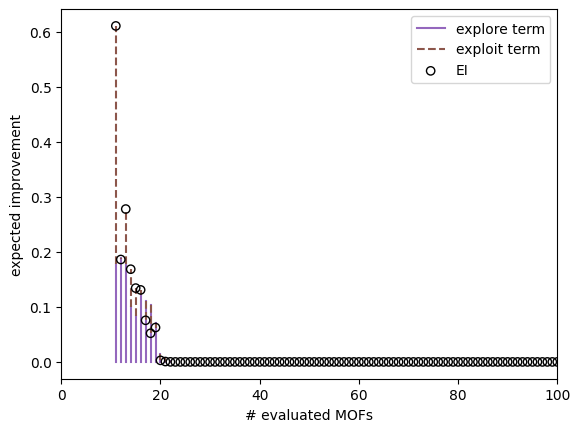

In [ ]:
# Diagram for comparing BO in 100% Explore and 100% Exploit modes:
explore_exploit_acquisition_terms = bo_res['explore_exploit_balance'][which_BO_run]

explore_term = np.array([ee_i[0] for ee_i in explore_exploit_acquisition_terms])
exploit_term = np.array([ee_i[1] for ee_i in explore_exploit_acquisition_terms])

plt.figure()
plt.xlabel('# evaluated MOFs')
plt.ylabel('expected improvement')
for i in range(nb_iterations):
    plt.plot([i+1, i+1], [0, explore_term[i]], color="C4")
    plt.plot([i+1, i+1], [explore_term[i], explore_term[i] + exploit_term[i]], color="C5", linestyle="--")
plt.plot([], [], color="C4", label="explore term")
plt.plot([], [], color="C5", label="exploit term", linestyle="--")
plt.scatter(np.arange(1, nb_iterations+1), explore_term + exploit_term, edgecolor="k", label="EI", zorder=100, facecolor="None")
plt.legend()
plt.xlim([0, 100])
plt.savefig("explore_exploit_balance.pdf", format="pdf")
plt.show()

In [ ]:
# Some helper functions to plot average search efficiency for each optimization technique
def y_max(res, rank=False):
    y_max_mu      = np.zeros(nb_iterations)
    y_max_sig_bot = np.zeros(nb_iterations)
    y_max_sig_top = np.zeros(nb_iterations)
    for i in range(1, nb_iterations+1):
        if rank:
            y_maxes = np.array([np.min(y_ranks[res['ids_acquired'][r]][:i]) for r in range(nb_runs)]) # among runs
        else:
            temp = [(y[res['ids_acquired'][r]][:i]) for r in range(nb_runs)]
            y_maxes = np.array([np.max(y[res['ids_acquired'][r]][:i]) for r in range(nb_runs)]) # among runs
        assert np.size(y_maxes) == nb_runs
        y_max_mu[i-1]      = np.mean(y_maxes)
        y_max_sig_bot[i-1] = np.std(y_maxes[ y_maxes < y_max_mu[i-1] ])
        y_max_sig_top[i-1] = np.std(y_maxes[y_maxes > y_max_mu[i-1]])
    return y_max_mu, y_max_sig_bot, y_max_sig_top

y_max_mu_BO, y_max_sig_bot_BO, y_max_sig_top_BO = y_max(bo_res)
y_max_mu_es, y_max_sig_bot_es, y_max_sig_top_es = y_max(es_res)
y_max_mu_rs, y_max_sig_bot_rs, y_max_sig_top_rs = y_max(rs_res)
y_max_mu_BO_explore, y_max_sig_bot_BO_explore, y_max_sig_top_BO_explore = y_max(bo_res_explore)
y_max_mu_BO_exploit, y_max_sig_bot_BO_exploit, y_max_sig_top_BO_exploit = y_max(bo_res_exploit)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# We need to write a separate method for Random Forest Search
def y_max_rf(res, rank=False):
    # one for each # of evaluation budgets
    y_max_mu      = np.zeros(len(res['nb_evals_budgets']))
    y_max_sig_bot = np.zeros(len(res['nb_evals_budgets']))
    y_max_sig_top = np.zeros(len(res['nb_evals_budgets']))
    for b in range(len(res['nb_evals_budgets'])):
        if rank:
            y_maxes = np.array([np.min(y_ranks[res['ids_acquired'][b][r]]) for r in range(nb_runs)])
        else:
            y_maxes = np.array([np.max(y[res['ids_acquired'][b][r]]) for r in range(nb_runs)])
        assert np.size(y_maxes) == nb_runs
        y_max_mu[b]      = np.mean(y_maxes)
        y_max_sig_bot[b] = np.std(y_maxes[y_maxes < y_max_mu[b]])
        y_max_sig_top[b] = np.std(y_maxes[y_maxes > y_max_mu[b]])
    return y_max_mu, y_max_sig_bot, y_max_sig_top

y_max_mu_rf,     y_max_sig_bot_rf,     y_max_sig_top_rf     = y_max_rf(rf_res)
y_max_mu_rf_div, y_max_sig_bot_rf_div, y_max_sig_top_rf_div = y_max_rf(rf_div_res)

In [ ]:
nb_iterations_range = np.arange(nb_iterations) + 1

# We moved the same calcuations for PSO and EPSO to their own separate files:

y_max_mu_pso = np.array(pickle.load(open('pso_graph_outputs.pkl', 'rb'))['y_max_mu_pso'])
y_max_sig_bot_pso = np.array(pickle.load(open('pso_graph_outputs.pkl', 'rb'))['y_max_sig_bot_pso'])
y_max_sig_top_pso = np.array(pickle.load(open('pso_graph_outputs.pkl', 'rb'))['y_max_sig_top_pso'])

y_max_mu_epso = np.array(pickle.load(open('epso_graph_outputs.pkl', 'rb'))['y_max_mu_epso'])
y_max_sig_bot_epso = np.array(pickle.load(open('epso_graph_outputs.pkl', 'rb'))['y_max_sig_bot_epso'])
y_max_sig_top_epso = np.array(pickle.load(open('epso_graph_outputs.pkl', 'rb'))['y_max_sig_top_epso'])

x_values_pso = np.arange(1, 50 + 1) # We're manually putting these values in, it's much easier
x_values_epso = np.arange(1, 39 + 1) # We're manually putting these values in, it's much easier

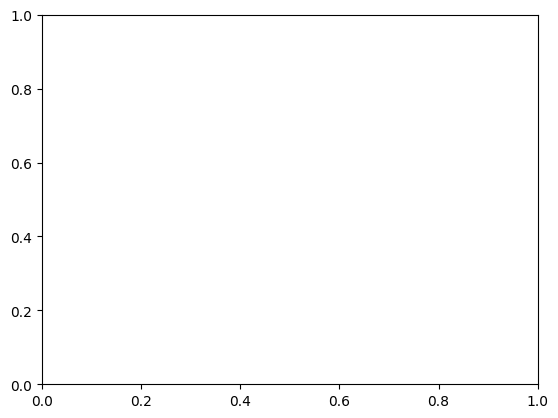

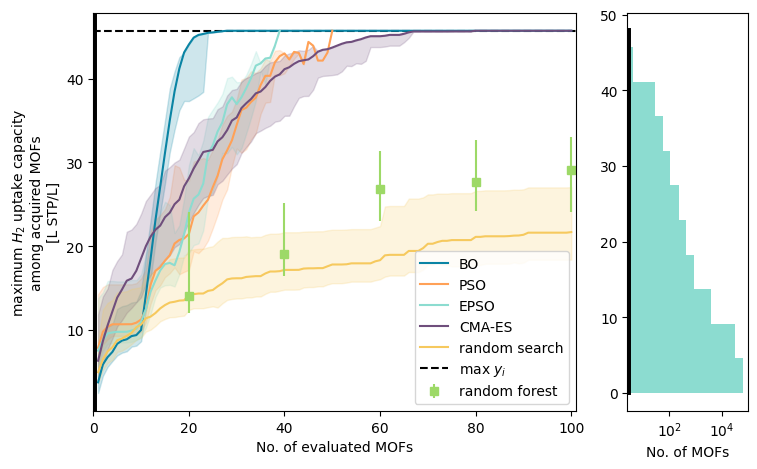

In [ ]:
# Plotting the Search Efficiency Diagram (with a number of MOFs in the database that correspond to maximum H_2 uptake capacity):
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[1.2 * 6.4, 4.8])
axs[0].plot(nb_iterations_range, y_max_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
axs[0].fill_between(nb_iterations_range, y_max_mu_BO - y_max_sig_bot_BO,
                                         y_max_mu_BO + y_max_sig_top_BO,
                    alpha=0.2, ec="None", color=search_to_color['BO'])

# PSO
axs[0].plot(x_values_pso, y_max_mu_pso, label='PSO', color=search_to_color['PSO'], clip_on=False)
axs[0].fill_between(x_values_pso, y_max_mu_pso - y_max_sig_bot_pso,
                                         y_max_mu_pso + y_max_sig_top_pso,
                    alpha=0.2, ec="None", color=search_to_color['PSO'])

# EPSO
axs[0].plot(x_values_epso, y_max_mu_epso, label='EPSO', color=search_to_color['EPSO'], clip_on=False)
axs[0].fill_between(x_values_epso, y_max_mu_epso - y_max_sig_bot_epso,
                                         y_max_mu_epso + y_max_sig_top_epso,
                    alpha=0.2, ec="None", color=search_to_color['EPSO'])

# ES
axs[0].plot(nb_iterations_range, y_max_mu_es, label='CMA-ES', color=search_to_color['evolutionary'], clip_on=False)
axs[0].fill_between(nb_iterations_range, y_max_mu_es - y_max_sig_bot_es,
                                         y_max_mu_es + y_max_sig_top_es,
                    alpha=0.2, ec="None", color=search_to_color['evolutionary'])

# RS
axs[0].plot(nb_iterations_range, y_max_mu_rs, label='random search', color=search_to_color['random'], clip_on=False)
axs[0].fill_between(nb_iterations_range, y_max_mu_rs - y_max_sig_bot_rs,
                                         y_max_mu_rs + y_max_sig_top_rs,
                    alpha=0.2, ec="None", color=search_to_color['random'])

axs[0].set_xlabel('No. of evaluated MOFs')
axs[0].set_ylabel('maximum $H_2$ uptake capacity\namong acquired MOFs\n[L STP/L]')


# RFs
axs[0].errorbar(rf_res['nb_evals_budgets'],     y_max_mu_rf,     yerr=np.vstack((y_max_sig_bot_rf,     y_max_sig_top_rf)),     color=search_to_color['RF'],       marker="s", label="random forest", linestyle="none")

axs[0].axhline(y=np.max(y), color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
axs[0].set_xlim([0, nb_iterations+1])
axs[0].legend()
ylim_ax0 = axs[0].get_ylim()
axs[0].plot([0, 0], ylim_ax0, color="k", lw=5)
axs[0].set_ylim(ylim_ax0)

axs[1].hist(y, orientation="horizontal", color=cool_colors[6])
axs[1].set_xlabel("No. of MOFs")
axs[1].set_xscale("log")
xlim_ax1 = axs[1].get_xlim()
axs[1].plot([xlim_ax1[0], xlim_ax1[0]], ylim_ax0, color="k", lw=5)
axs[1].set_xlim(xlim_ax1)

plt.tight_layout()
plt.savefig("search_efficiency_max_found_with_num_final.pdf")
plt.show()

ylims_for_below = plt.gca().get_ylim()

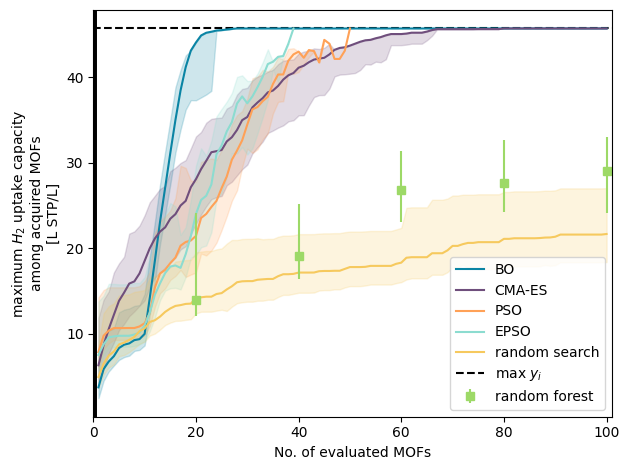

In [ ]:
# The same plot as before, without the extra plot on the side
plt.plot(nb_iterations_range, y_max_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO - y_max_sig_bot_BO,
                                         y_max_mu_BO + y_max_sig_top_BO,
                    alpha=0.2, ec="None", color=search_to_color['BO'])

# ES
plt.plot(nb_iterations_range, y_max_mu_es, label='CMA-ES', color=search_to_color['evolutionary'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_es - y_max_sig_bot_es,
                                         y_max_mu_es + y_max_sig_top_es,
                    alpha=0.2, ec="None", color=search_to_color['evolutionary'])

# PSO
plt.plot(x_values_pso, y_max_mu_pso, label='PSO', color=search_to_color['PSO'], clip_on=False)
plt.fill_between(x_values_pso, y_max_mu_pso - y_max_sig_bot_pso,
                                         y_max_mu_pso + y_max_sig_top_pso,
                    alpha=0.2, ec="None", color=search_to_color['PSO'])

# EPSO
plt.plot(x_values_epso, y_max_mu_epso, label='EPSO', color=search_to_color['EPSO'], clip_on=False)
plt.fill_between(x_values_epso, y_max_mu_epso - y_max_sig_bot_epso,
                                         y_max_mu_epso + y_max_sig_top_epso,
                    alpha=0.2, ec="None", color=search_to_color['EPSO'])

# RS
plt.plot(nb_iterations_range, y_max_mu_rs, label='random search', color=search_to_color['random'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_rs - y_max_sig_bot_rs,
                                         y_max_mu_rs + y_max_sig_top_rs,
                    alpha=0.2, ec="None", color=search_to_color['random'])

plt.xlabel('No. of evaluated MOFs')
plt.ylabel('maximum $H_2$ uptake capacity\namong acquired MOFs\n[L STP/L]')


# RFs
plt.errorbar(rf_res['nb_evals_budgets'],     y_max_mu_rf,     yerr=np.vstack((y_max_sig_bot_rf,     y_max_sig_top_rf)),     color=search_to_color['RF'],       marker="s", label="random forest", linestyle="none")

plt.axhline(y=np.max(y), color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, nb_iterations+1])
plt.legend()
ylim_ax0 = axs[0].get_ylim()
plt.plot([0, 0], ylim_ax0, color="k", lw=5)
plt.ylim(ylim_ax0)

plt.tight_layout()
plt.savefig("search_efficiency_max_found_final.pdf")
plt.show()

ylims_for_below = plt.gca().get_ylim()

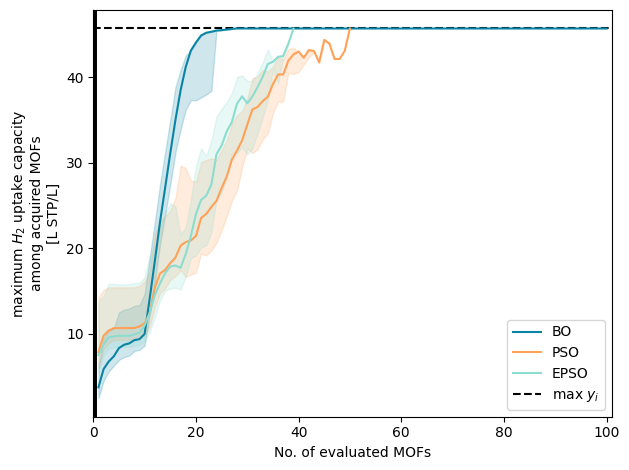

In [ ]:
# Only plotting for BO, PSO, and EPSO
plt.plot(nb_iterations_range, y_max_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO - y_max_sig_bot_BO,
                                         y_max_mu_BO + y_max_sig_top_BO,
                    alpha=0.2, ec="None", color=search_to_color['BO'])

# PSO
plt.plot(x_values_pso, y_max_mu_pso, label='PSO', color=search_to_color['PSO'], clip_on=False)
plt.fill_between(x_values_pso, y_max_mu_pso - y_max_sig_bot_pso,
                                         y_max_mu_pso + y_max_sig_top_pso,
                    alpha=0.2, ec="None", color=search_to_color['PSO'])

# EPSO
plt.plot(x_values_epso, y_max_mu_epso, label='EPSO', color=search_to_color['EPSO'], clip_on=False)
plt.fill_between(x_values_epso, y_max_mu_epso - y_max_sig_bot_epso,
                                         y_max_mu_epso + y_max_sig_top_epso,
                    alpha=0.2, ec="None", color=search_to_color['EPSO'])


plt.xlabel('No. of evaluated MOFs')
plt.ylabel('maximum $H_2$ uptake capacity\namong acquired MOFs\n[L STP/L]')


plt.axhline(y=np.max(y), color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, nb_iterations+1])
plt.legend()
ylim_ax0 = axs[0].get_ylim()
plt.plot([0, 0], ylim_ax0, color="k", lw=5)
plt.ylim(ylim_ax0)

plt.tight_layout()
plt.savefig("search_efficiency_max_found_bo_pso_epso_final.pdf")
plt.show()

ylims_for_below = plt.gca().get_ylim()

In [ ]:
# We also repeat these plots for "fixed" output of PSO and EPSO
nb_iterations_range = np.arange(nb_iterations) + 1

y_max_mu_pso_fixed = np.array(pickle.load(open('pso_graph_outputs_fixed.pkl', 'rb'))['y_max_mu_pso_fixed'])
y_max_sig_bot_pso_fixed = np.array(pickle.load(open('pso_graph_outputs_fixed.pkl', 'rb'))['y_max_sig_bot_pso_fixed'])
y_max_sig_top_pso_fixed = np.array(pickle.load(open('pso_graph_outputs_fixed.pkl', 'rb'))['y_max_sig_top_pso_fixed'])

y_max_mu_epso_fixed = np.array(pickle.load(open('epso_graph_outputs_fixed.pkl', 'rb'))['y_max_mu_epso_fixed'])
y_max_sig_bot_epso_fixed = np.array(pickle.load(open('epso_graph_outputs_fixed.pkl', 'rb'))['y_max_sig_bot_epso_fixed'])
y_max_sig_top_epso_fixed = np.array(pickle.load(open('epso_graph_outputs_fixed.pkl', 'rb'))['y_max_sig_top_epso_fixed'])

x_values_pso_fixed = np.arange(1, 50 + 1)
x_values_epso_fixed = np.arange(1, 39 + 1)

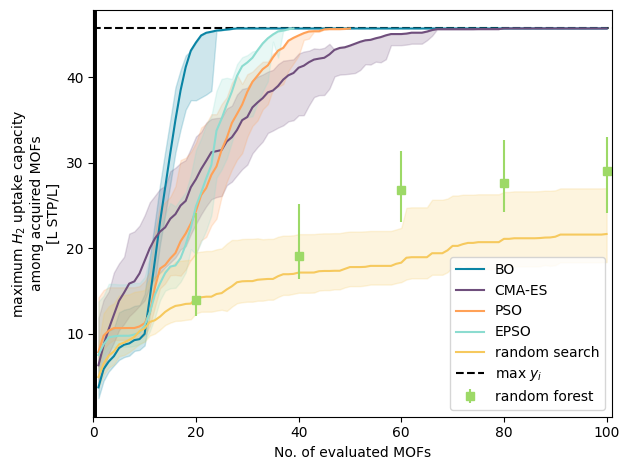

In [ ]:
# Again, the same plots
plt.plot(nb_iterations_range, y_max_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO - y_max_sig_bot_BO,
                                         y_max_mu_BO + y_max_sig_top_BO,
                    alpha=0.2, ec="None", color=search_to_color['BO'])

# ES
plt.plot(nb_iterations_range, y_max_mu_es, label='CMA-ES', color=search_to_color['evolutionary'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_es - y_max_sig_bot_es,
                                         y_max_mu_es + y_max_sig_top_es,
                    alpha=0.2, ec="None", color=search_to_color['evolutionary'])

# PSO
plt.plot(x_values_pso_fixed, y_max_mu_pso_fixed, label='PSO', color=search_to_color['PSO'], clip_on=False)
plt.fill_between(x_values_pso_fixed, y_max_mu_pso_fixed - y_max_sig_bot_pso_fixed,
                                         y_max_mu_pso_fixed + y_max_sig_top_pso_fixed,
                    alpha=0.2, ec="None", color=search_to_color['PSO'])

# EPSO
plt.plot(x_values_epso_fixed, y_max_mu_epso_fixed, label='EPSO', color=search_to_color['EPSO'], clip_on=False)
plt.fill_between(x_values_epso_fixed, y_max_mu_epso_fixed - y_max_sig_bot_epso_fixed,
                                         y_max_mu_epso_fixed + y_max_sig_top_epso_fixed,
                    alpha=0.2, ec="None", color=search_to_color['EPSO'])

# RS
plt.plot(nb_iterations_range, y_max_mu_rs, label='random search', color=search_to_color['random'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_rs - y_max_sig_bot_rs,
                                         y_max_mu_rs + y_max_sig_top_rs,
                    alpha=0.2, ec="None", color=search_to_color['random'])

plt.xlabel('No. of evaluated MOFs')
plt.ylabel('maximum $H_2$ uptake capacity\namong acquired MOFs\n[L STP/L]')


# RFs
plt.errorbar(rf_res['nb_evals_budgets'],     y_max_mu_rf,     yerr=np.vstack((y_max_sig_bot_rf,     y_max_sig_top_rf)),     color=search_to_color['RF'],       marker="s", label="random forest", linestyle="none")

plt.axhline(y=np.max(y), color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, nb_iterations+1])
plt.legend()
ylim_ax0 = axs[0].get_ylim()
plt.plot([0, 0], ylim_ax0, color="k", lw=5)
plt.ylim(ylim_ax0)

plt.tight_layout()
plt.savefig("search_efficiency_max_found_final_fixed.pdf")
plt.show()

ylims_for_below = plt.gca().get_ylim()

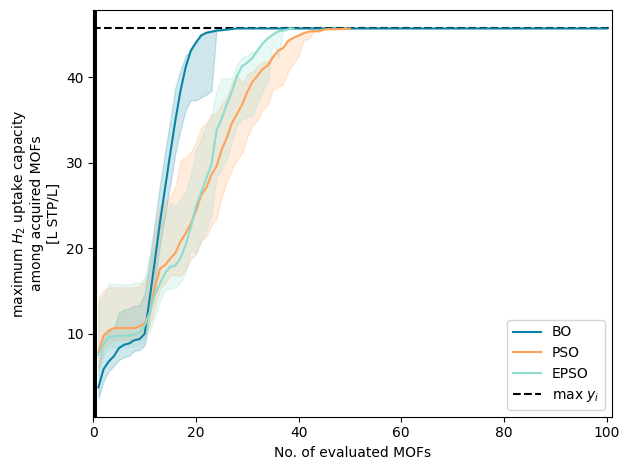

In [ ]:
# Again, the same plots
plt.plot(nb_iterations_range, y_max_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO - y_max_sig_bot_BO,
                                         y_max_mu_BO + y_max_sig_top_BO,
                    alpha=0.2, ec="None", color=search_to_color['BO'])

# PSO
plt.plot(x_values_pso_fixed, y_max_mu_pso_fixed, label='PSO', color=search_to_color['PSO'], clip_on=False)
plt.fill_between(x_values_pso_fixed, y_max_mu_pso_fixed - y_max_sig_bot_pso_fixed,
                                         y_max_mu_pso_fixed + y_max_sig_top_pso_fixed,
                    alpha=0.2, ec="None", color=search_to_color['PSO'])

# EPSO
plt.plot(x_values_epso_fixed, y_max_mu_epso_fixed, label='EPSO', color=search_to_color['EPSO'], clip_on=False)
plt.fill_between(x_values_epso_fixed, y_max_mu_epso_fixed - y_max_sig_bot_epso_fixed,
                                         y_max_mu_epso_fixed + y_max_sig_top_epso_fixed,
                    alpha=0.2, ec="None", color=search_to_color['EPSO'])


plt.xlabel('No. of evaluated MOFs')
plt.ylabel('maximum $H_2$ uptake capacity\namong acquired MOFs\n[L STP/L]')


plt.axhline(y=np.max(y), color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, nb_iterations+1])
plt.legend()
ylim_ax0 = axs[0].get_ylim()
plt.plot([0, 0], ylim_ax0, color="k", lw=5)
plt.ylim(ylim_ax0)

plt.tight_layout()
plt.savefig("search_efficiency_max_found_bo_pso_epso_final_fixed.pdf")
plt.show()

ylims_for_below = plt.gca().get_ylim()

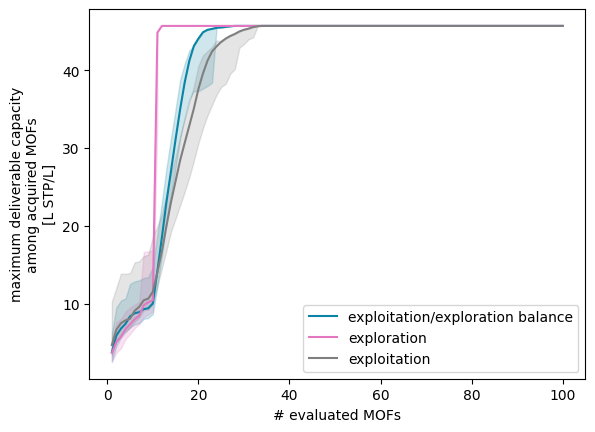

In [ ]:
# 100% Explore vs 100% Exploit diagram
plt.plot(nb_iterations_range, y_max_mu_BO, label='exploitation/exploration balance', color=search_to_color['BO'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO - y_max_sig_bot_BO,
                                      y_max_mu_BO + y_max_sig_top_BO,
                    alpha=0.2, ec="None", color=search_to_color['BO'])

plt.plot(nb_iterations_range, y_max_mu_BO_explore, label='exploration', color="C6", clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO_explore - y_max_sig_bot_BO_explore,
                                      y_max_mu_BO_explore + y_max_sig_top_BO_explore,
                    alpha=0.2, ec="None", color="C6")

plt.plot(nb_iterations_range, y_max_mu_BO_exploit, label='exploitation', color="C7", clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO_exploit - y_max_sig_bot_BO_exploit,
                                      y_max_mu_BO_exploit + y_max_sig_top_BO_exploit,
                    alpha=0.2, ec="None", color="C7")

plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')
plt.legend()
plt.savefig("full_explore_exploit_balance_mof.pdf")
plt.show()
plt.tight_layout()

In [ ]:
y_max_mu_BO, y_max_sig_bot_BO, y_max_sig_top_BO = y_max(bo_res, rank=True)
y_max_mu_es, y_max_sig_bot_es, y_max_sig_top_es = y_max(es_res, rank=True)
y_max_mu_rs, y_max_sig_bot_rs, y_max_sig_top_rs = y_max(rs_res, rank=True)

y_max_mu_rf,     y_max_sig_bot_rf,     y_max_sig_top_rf     = y_max_rf(rf_res, rank=True)
y_max_mu_rf_div, y_max_sig_bot_rf_div, y_max_sig_top_rf_div = y_max_rf(rf_div_res, rank=True)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


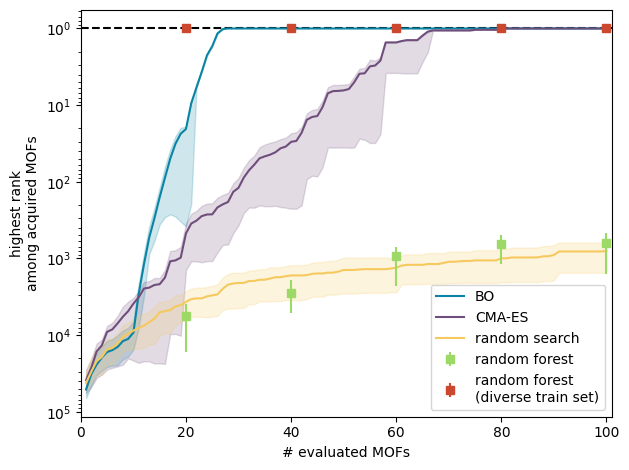

In [ ]:
# Plotting a similar graph, except for max ranks instead of H_2 uptake capacity
plt.figure()

plt.plot(nb_iterations_range, y_max_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_BO - y_max_sig_bot_BO,
                                      y_max_mu_BO + y_max_sig_top_BO,
                 alpha=0.2, ec="None", color=search_to_color['BO'])

plt.plot(nb_iterations_range, y_max_mu_es, label='CMA-ES', color=search_to_color['evolutionary'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_es - y_max_sig_bot_es,
                                      y_max_mu_es + y_max_sig_top_es,
                 alpha=0.2, ec="None", color=search_to_color['evolutionary'])

plt.plot(nb_iterations_range, y_max_mu_rs, label='random search', color=search_to_color['random'], clip_on=False)
plt.fill_between(nb_iterations_range, y_max_mu_rs - y_max_sig_bot_rs,
                                      y_max_mu_rs + y_max_sig_top_rs,
                 alpha=0.2, ec="None", color=search_to_color['random'])

# RFs
plt.errorbar(rf_res['nb_evals_budgets'],     y_max_mu_rf,     yerr=np.vstack((y_max_sig_bot_rf,     y_max_sig_top_rf)),     color=search_to_color['RF'],       marker="s", label="random forest", linestyle="None")
plt.errorbar(rf_div_res['nb_evals_budgets'], y_max_mu_rf_div, yerr=np.vstack((y_max_sig_bot_rf_div, y_max_sig_top_rf_div)), color=search_to_color['RF (div)'], marker="s", label="random forest\n(diverse train set)", linestyle="None")

plt.xlabel('# evaluated MOFs')
plt.ylabel('highest rank\namong acquired MOFs')
plt.xlim([0, nb_iterations+1])
plt.legend()
plt.axhline(y=1, color="k", linestyle="--", zorder=0)
plt.yticks()
plt.xticks()
plt.yscale("log")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("search_efficiency_rank.pdf")
plt.show()

In [ ]:
# Statistics/Facts that are printed in the paper
nb_bo_runs_to_get_top_mof = np.argmax(y_max_mu_BO == 1)
print("# evals by BO req'd to reach top MOF in all runs:", nb_bo_runs_to_get_top_mof)

# evals by BO req'd to reach top MOF in all runs: 27


In [ ]:
print("after ", rf_res['nb_evals_budgets'][-1],    "iterations, top-ranked MOF found by RF:", y_max_mu_rf[-1])
print("after ", rf_div_res['nb_evals_budgets'][-1], "iterations, top-ranked MOF found by RF (div):", y_max_mu_rf_div[-1])

print("after ", np.size(y_max_mu_es), "iterations, top-ranked MOF found by CMA-ES:", y_max_mu_es[-1])
print("after ", np.size(y_max_mu_rs), "iterations, top-ranked MOF found by rs:", y_max_mu_rs[-1])

after  100 iterations, top-ranked MOF found by RF: 632.72
after  100 iterations, top-ranked MOF found by RF (div): 1.0
after  100 iterations, top-ranked MOF found by CMA-ES: 1.0
after  100 iterations, top-ranked MOF found by rs: 797.94


In [ ]:
top_100_MOF_ids = np.flip(np.argsort(y))[:100]
assert np.size(top_100_MOF_ids) == 100
print("top 100 MOFs range from y =", np.min(y[top_100_MOF_ids]), "to", np.max(y[top_100_MOF_ids]))

top 100 MOFs range from y = 31.1 to 45.71


In [ ]:
# A little helper function
def fraction_in_top100_cofs(ids_acquired):
    nb_in_top_100 = 0
    for id_acquired in ids_acquired:
        if id_acquired in top_100_MOF_ids:
            nb_in_top_100 += 1
    return nb_in_top_100 / 100

In [ ]:
# Getting the fraction of acquired MOFs that are in the top 100
def y_top_100(res):
    y_top100_mu      = np.zeros(nb_iterations)
    y_top100_sig_bot = np.zeros(nb_iterations)
    y_top100_sig_top = np.zeros(nb_iterations)
    for i in range(1, nb_iterations+1):
        y_top100s = np.array([fraction_in_top100_cofs(res['ids_acquired'][r][:i]) for r in range(nb_runs)])
        y_top100_mu[i-1]      = np.mean(y_top100s)
        y_top100_sig_bot[i-1] = np.std(y_top100s[y_top100s < y_top100_mu[i-1]])
        y_top100_sig_top[i-1] = np.std(y_top100s[y_top100s > y_top100_mu[i-1]])
    return y_top100_mu, y_top100_sig_bot, y_top100_sig_top

y_top100_mu_BO, y_top100_sig_bot_BO, y_top100_sig_top_BO = y_top_100(bo_res)
y_top100_mu_es, y_top100_sig_bot_es, y_top100_sig_top_es = y_top_100(es_res)
y_top100_mu_rs, y_top100_sig_bot_rs, y_top100_sig_top_rs = y_top_100(rs_res)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
print("fraction of top 100 acquired after ", nb_bo_runs_to_get_top_mof, "runs:", y_top100_mu_BO[nb_bo_runs_to_get_top_mof])

fraction of top 100 acquired after  27 runs: 0.07120000000000001


In [ ]:
# Same thing, except for Random Forest Search
def y_top_100_rf(rf_res, rank=False):
    # one for each # of evaluation budgets
    y_top100_mu      = np.zeros(len(rf_res['nb_evals_budgets']))
    y_top100_sig_bot = np.zeros(len(rf_res['nb_evals_budgets']))
    y_top100_sig_top = np.zeros(len(rf_res['nb_evals_budgets']))
    for b in range(len(rf_res['nb_evals_budgets'])):
        y_top100s = np.array([fraction_in_top100_cofs(rf_res['ids_acquired'][b][r]) for r in range(nb_runs)])
        assert np.size(y_top100s) == nb_runs
        y_top100_mu[b]      = np.mean(y_top100s)
        y_top100_sig_bot[b] = np.std(y_top100s[y_top100s < y_top100_mu[b]])
        y_top100_sig_top[b] = np.std(y_top100s[y_top100s > y_top100_mu[b]])
    return y_top100_mu, y_top100_sig_bot, y_top100_sig_top

y_top100_mu_rf,    y_top100_sig_bot_rf,     y_top100_sig_top_rf     = y_top_100_rf(rf_res)
y_top100_mu_rf_div, y_top100_sig_bot_rf_div, y_top100_sig_top_rf_div = y_top_100_rf(rf_div_res)

print(y_top100_mu_rf)

[0.003  0.0092 0.0276 0.0378 0.0558]


In [ ]:
samples = [9, 19, 29, 39, 49]
print("Random Search: ", y_top100_mu_rs[samples[0]], "| ", y_top100_mu_rs[samples[1]], "| ", y_top100_mu_rs[samples[2]], "| ", y_top100_mu_rs[samples[3]], "| ", y_top100_mu_rs[samples[4]], "| " )
print("Evolutionary Search: ", y_top100_mu_es[samples[0]], "| ", y_top100_mu_es[samples[1]], "| ", y_top100_mu_es[samples[2]], "| ", y_top100_mu_es[samples[3]], "| ", y_top100_mu_es[samples[4]], "| " )
print("Bayesian Optimization: ", y_top100_mu_BO[samples[0]], "| ", y_top100_mu_BO[samples[1]], "| ", y_top100_mu_BO[samples[2]], "| ", y_top100_mu_BO[samples[3]], "| ", y_top100_mu_BO[samples[4]], "| " )


Random Search:  0.0 |  0.0 |  0.0002 |  0.0002 |  0.0002 | 
Evolutionary Search:  0.0002 |  0.004800000000000001 |  0.0254 |  0.06540000000000001 |  0.1232 | 
Bayesian Optimization:  0.0 |  0.04699999999999999 |  0.07460000000000001 |  0.09979999999999999 |  0.1278 | 


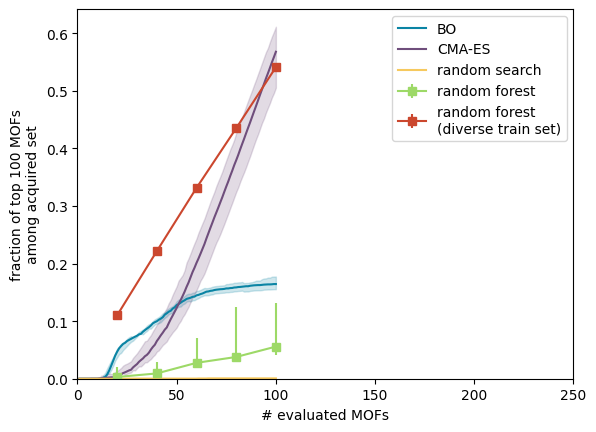

In [ ]:
plt.figure()
plt.ylabel('fraction of top 100 MOFs\namong acquired set')
plt.xlabel('# evaluated MOFs')

plt.plot(nb_iterations_range, y_top100_mu_BO, label='BO', color=search_to_color['BO'], clip_on=False)
plt.fill_between(nb_iterations_range, y_top100_mu_BO - y_top100_sig_bot_BO,
                                      y_top100_mu_BO + y_top100_sig_top_BO,
                 alpha=0.2, ec="None", color=search_to_color['BO'])

plt.plot(nb_iterations_range, y_top100_mu_es, label='CMA-ES', color=search_to_color['evolutionary'], clip_on=False)
plt.fill_between(nb_iterations_range, y_top100_mu_es - y_top100_sig_bot_es,
                                      y_top100_mu_es + y_top100_sig_top_es,
                 alpha=0.2, ec="None", color=search_to_color['evolutionary'])

plt.plot(nb_iterations_range, y_top100_mu_rs, label='random search', color=search_to_color['random'], clip_on=False)
plt.fill_between(nb_iterations_range, y_top100_mu_rs - y_top100_sig_bot_rs,
                                      y_top100_mu_rs + y_top100_sig_top_rs,
                 alpha=0.2, ec="None", color=search_to_color['random'])

# RFs
plt.errorbar(rf_res['nb_evals_budgets'],     y_top100_mu_rf,     yerr=np.vstack((y_top100_sig_bot_rf,     y_top100_sig_top_rf)),     color=search_to_color['RF'],       marker="s", label="random forest")
plt.errorbar(rf_div_res['nb_evals_budgets'], y_top100_mu_rf_div, yerr=np.vstack((y_top100_sig_bot_rf_div, y_top100_sig_top_rf_div)), color=search_to_color['RF (div)'], marker="s", label="random forest\n(diverse train set)")

plt.xlim([0, 250])
plt.ylim(ymin=0.0)
plt.xticks()
plt.yticks()
plt.legend()
plt.savefig("search_efficiency_top100.pdf", format="pdf")
plt.show()

In [ ]:
print("after ", rf_res['nb_evals_budgets'][-1],    "iterations, fraction top 100 MOFs found by RF:", y_top100_mu_rf[-1])
print("after ", rf_div_res['nb_evals_budgets'][-1], "iterations, fraction top 100 MOFs found by RF (div):", y_top100_mu_rf_div[-1])

print("after ", np.size(y_top100_mu_BO), "iterations, fraction top 100 MOFs found by BO:", y_top100_mu_BO[-1])
print("after ", np.size(y_top100_mu_es), "iterations, fraction top 100 MOFs found by CMA-ES:", y_top100_mu_es[-1])
print("after ", np.size(y_top100_mu_rs), "iterations, fraction top 100 MOFs found by RS:", y_top100_mu_rs[-1])

after  100 iterations, fraction top 100 MOFs found by RF: 0.0558
after  100 iterations, fraction top 100 MOFs found by RF (div): 0.5409999999999999
after  100 iterations, fraction top 100 MOFs found by BO: 0.16440000000000002
after  100 iterations, fraction top 100 MOFs found by CMA-ES: 0.5678
after  100 iterations, fraction top 100 MOFs found by RS: 0.0006


## look at how search efficiency changes for BO in terms of the number of initially acquired COFs

In [ ]:
# load in array of # of MOFs initialized
nb_NOFs_initializeds = pickle.load(open('bo_results_nb_COF_initializations.pkl', 'rb'))['EI']
nb_NOFs_initializeds

[5, 10, 15, 20, 25]

In [ ]:
# color curves according to # COFs used in the init
cmap = sns.color_palette("flare", as_cmap=True)

def nb_COFs_to_color(x):
    the_range = np.max(nb_NOFs_initializeds) - np.min(nb_NOFs_initializeds)
    return cmap((x - np.min(nb_NOFs_initializeds)) / the_range)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


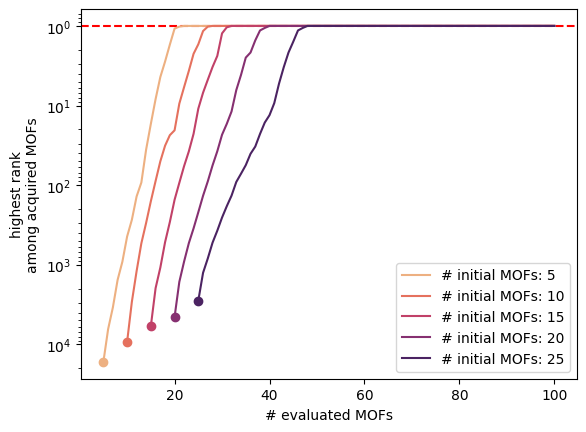

In [ ]:
# load in BO results for each number of initialized COFs
bo_ress = [pickle.load(open('bo_results_EI' + "_initiate_with_{0}".format(nb_COFs_initialized) + '.pkl', 'rb')) for nb_COFs_initialized in nb_NOFs_initializeds]
for res in bo_ress:
    assert len(res['ids_acquired']) == nb_runs
    assert len(res['ids_acquired'][0]) == nb_iterations

# plot
plt.figure()
for i in range(len(nb_NOFs_initializeds)):
    the_bo_res = bo_ress[i]
    y_max_mu, _, _ = y_max(the_bo_res, rank=True)
    y_max_mu[:(nb_NOFs_initializeds[i]-1)] = np.NaN

    plt.scatter([nb_NOFs_initializeds[i]], [y_max_mu[nb_NOFs_initializeds[i]-1]], color=nb_COFs_to_color(nb_NOFs_initializeds[i]))
    plt.plot(nb_iterations_range, y_max_mu, label='# initial MOFs: {}'.format(nb_NOFs_initializeds[i]), color=nb_COFs_to_color(nb_NOFs_initializeds[i]), clip_on=False)


plt.xlabel('# evaluated MOFs')
plt.ylabel('highest rank\namong acquired MOFs')
plt.legend(fontsize=1/4)
plt.axhline(y=1, color="r", linestyle="--", zorder=0)
plt.yticks()
plt.xticks()
plt.yscale("log")
plt.legend()
plt.gca().invert_yaxis()

plt.savefig("bo_search_res_with_different_mof_inits.pdf", format="pdf")
plt.show()

In [ ]:
# Calculating distances of each MOF in the database from the center of the search space:
center_MOF = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
np_center = np.array(center_MOF)
np_X = np.array(X)
difference = np_X - np_center

distance = []

for vector in difference:
    distance.append(np.linalg.norm(vector))

np_distance = np.array(distance)

max_dist = np.max(np_distance)
min_dist = np.min(np_distance)
print("max: ", max_dist, " | min: ", min_dist)

max:  1.2412844858390595  | min:  0.6810437015044813


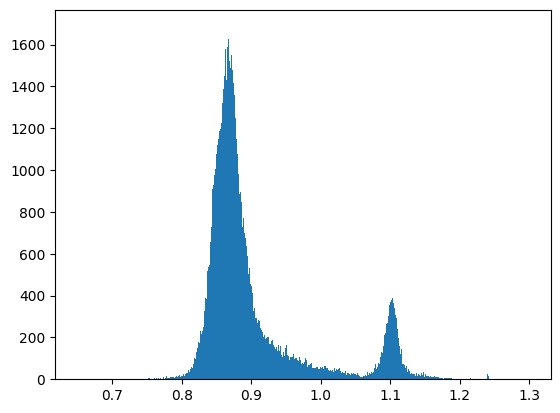

In [ ]:
bin_range = np.arange(0.65, 1.30, 0.001)
plt.hist(np_distance, bins=bin_range)
plt.show()

In [ ]:
# This is the list of the top 100 best performing MOFs:
top_MOFs = [28131, 25221, 25220, 30209, 27568, 28089, 29465, 28951, 29876, 30115, 30163, 29800,
 25998, 27615, 31121, 31080, 28788, 28132, 30545, 26305, 30798, 30640, 28178, 29133,
 30727, 28621, 29765, 31081, 31201, 30164, 31338, 31168, 30114, 29604, 29334, 28090,
 30410, 28999, 30951, 31120, 30680, 33515, 31119, 30728, 32561, 30512, 30487, 30409,
 32157, 31699, 31974, 32560, 31200, 31530, 30117, 31202, 29415, 32008, 32156, 31973,
 30919, 32274, 29848, 29000, 30797, 31600, 32401, 32450, 32060, 34054, 34095, 32558,
 34094, 34533, 34130, 32843, 31975, 31123, 33220, 32371, 32998, 32559, 32717, 32999,
 34167, 33795, 35132, 35131, 33713, 33918, 33872, 33581, 35168, 34290, 34291, 34166,
 35679, 35496, 35235, 36414]

top_10_MOFs = [33872, 33581, 35168, 34290, 34291, 34166,
 35679, 35496, 35235, 36414]

In [ ]:
top_distances = []
for ids in top_10_MOFs:
    top_distances.append(np.linalg.norm(np_X[ids] - np_center))

np_top_distances = np.array(top_distances)
print(np_top_distances)

[0.94842721 0.95913598 0.93433412 0.96303393 0.96490605 0.96611779
 0.9895623  1.00849186 1.03859752 1.12493126]


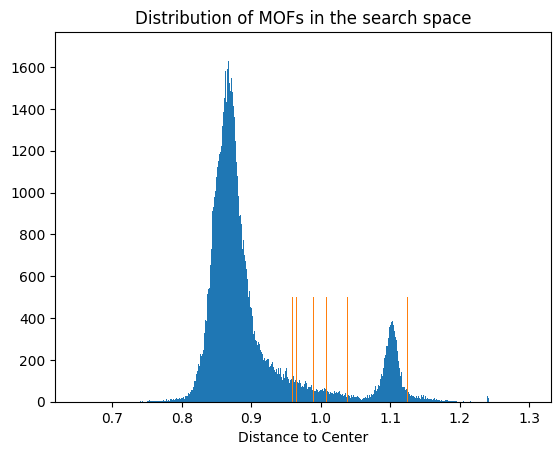

In [ ]:
plt.figure()

plt.title("Distribution of MOFs in the search space")
plt.xlabel("Distance to Center")

plt.hist(np_distance, bins=bin_range, color='C0')

plt.bar(np_top_distances, 500, 0.001, color='C1')

plt.savefig("distance_to_center_MOF.pdf", format="pdf")

plt.show()